In [19]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
transactions_df = pd.read_csv('Transactions.csv')
customers_df= pd.read_csv('Customers.csv')

In [22]:
merged_df = pd.merge(transactions_df, customers_df, on="CustomerID")


In [23]:
customer_data = merged_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'TransactionID': 'count',
    'Region': 'first',
    'SignupDate': 'first'
}).reset_index()

In [24]:
# Preprocess features
customer_data['SignupDate'] = pd.to_datetime(customer_data['SignupDate'])
customer_data['CustomerTenure'] = (pd.Timestamp.now() - customer_data['SignupDate']).dt.days
customer_data = customer_data.drop(columns=['SignupDate'])

In [25]:
# Encode categorical variables
label_encoder = LabelEncoder()
customer_data['RegionEncoded'] = label_encoder.fit_transform(customer_data['Region'])
customer_data = customer_data.drop(columns=['Region'])


In [26]:
# Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data.drop(columns=['CustomerID']))
scaled_customer_data = pd.DataFrame(scaled_features, columns=customer_data.columns[1:], index=customer_data['CustomerID'])

In [27]:
# Set the number of clusters to 4
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
final_labels = kmeans.fit_predict(scaled_customer_data)
scaled_customer_data['Cluster'] = final_labels

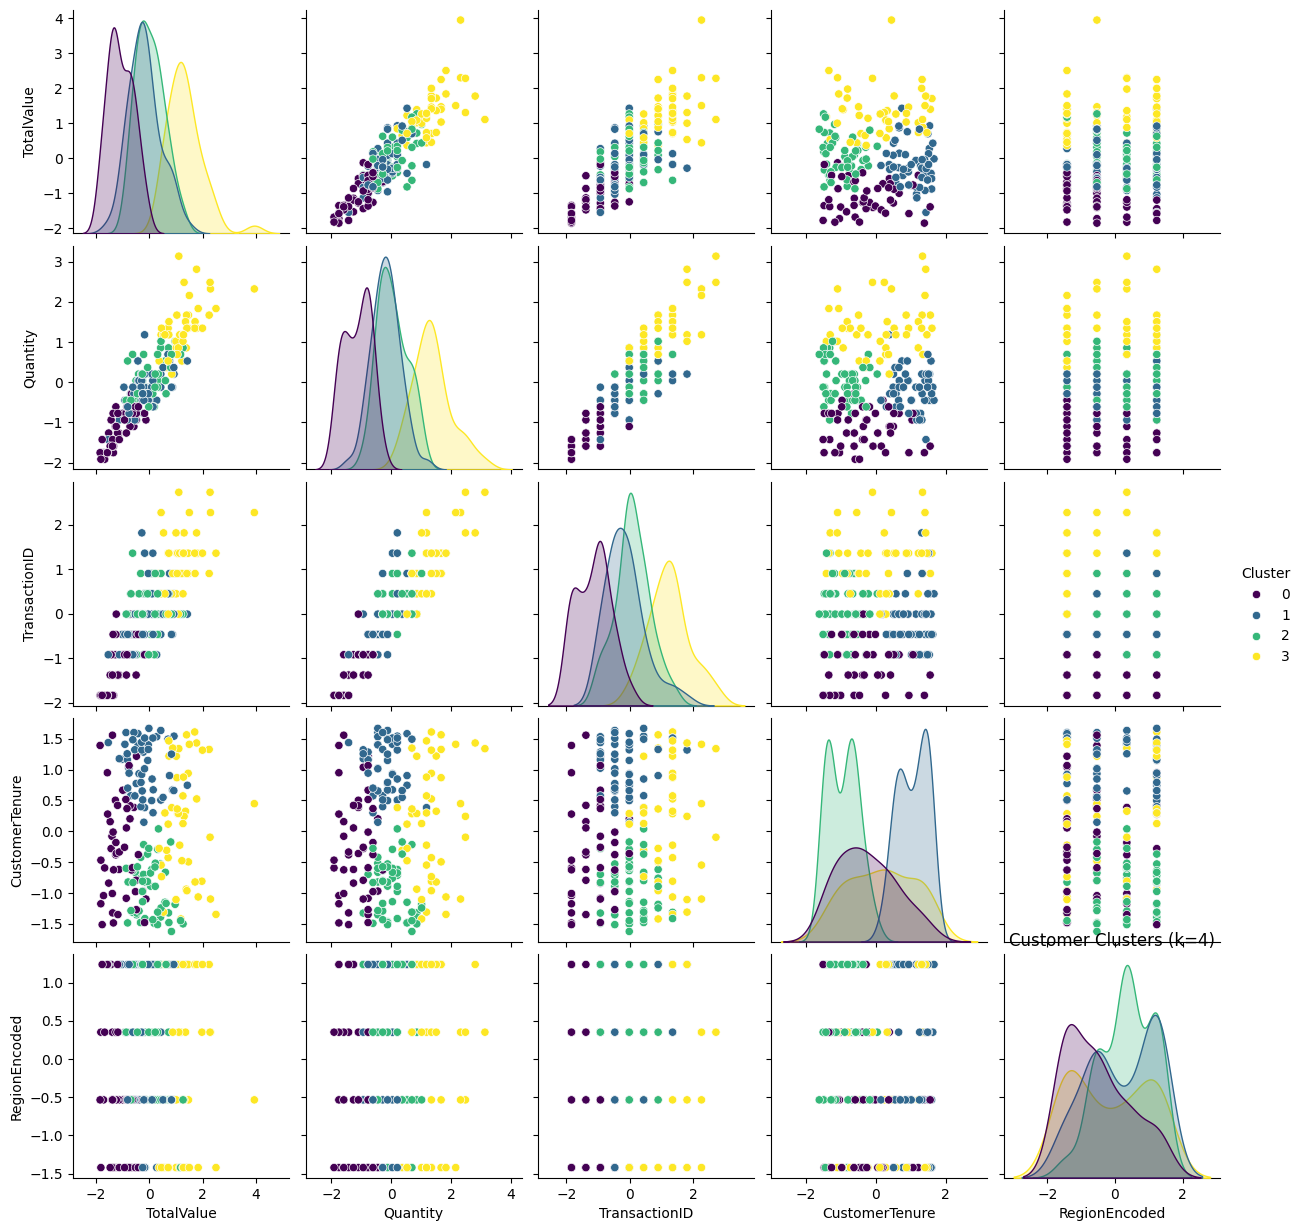

In [28]:
sns.pairplot(scaled_customer_data, hue='Cluster', diag_kind='kde', palette='viridis')
plt.title(f'Customer Clusters (k={k})')
plt.show()

In [29]:
clustered_customers = customer_data[['CustomerID']].copy()
clustered_customers['Cluster'] = final_labels

In [30]:

db_index = davies_bouldin_score(scaled_customer_data.drop(columns=['Cluster']), scaled_customer_data['Cluster'])
print(f"Davies-Bouldin Index (k=4): {db_index}")

Davies-Bouldin Index (k=4): 1.23986682871971


In [31]:
cluster_sizes = scaled_customer_data['Cluster'].value_counts()
print("Cluster Sizes:")
print(cluster_sizes)

Cluster Sizes:
Cluster
2    54
1    53
0    47
3    45
Name: count, dtype: int64


In [32]:
centroids = kmeans.cluster_centers_
print("Cluster Centroids (Scaled Features):")
print(centroids)

Cluster Centroids (Scaled Features):
[[-1.08175807 -1.1380798  -1.13699372 -0.25538097 -0.51528441]
 [-0.18645324 -0.19276171 -0.14052497  1.04787651  0.21793533]
 [ 0.02025114  0.04095066  0.08988313 -0.94411693  0.35163592]
 [ 1.32513532  1.36655079  1.2451742   0.16550589 -0.14045654]]


In [33]:
wcss = kmeans.inertia_
print(f"Within-Cluster Sum of Squares (WCSS): {wcss}")

Within-Cluster Sum of Squares (WCSS): 446.94341881198807


In [34]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(scaled_customer_data.drop(columns=['Cluster']), scaled_customer_data['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.23552018536279296


In [35]:
from sklearn.metrics import calinski_harabasz_score

ch_score = calinski_harabasz_score(scaled_customer_data.drop(columns=['Cluster']), scaled_customer_data['Cluster'])
print(f"Calinski-Harabasz Index: {ch_score}")


Calinski-Harabasz Index: 79.70511764534191
